In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

In [5]:
import sys
import numpy as np
import json
import torch
import nltk 
nltk.download('punkt')
import collections
from collections import Counter
import torch, torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import random
import math
import time

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})

device = 'cuda' if torch.cuda.is_available() else 'cpu'
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Базовая часть:

### 1. Предобработка текстов из датасета

In [6]:
%cd "/content/drive/MyDrive/OtherJupiterNotebooks/DLS_2_NLP/FinalProject"
# !pwd
# !tar -xf handout.tar

/content/drive/MyDrive/OtherJupiterNotebooks/DLS_2_NLP/FinalProject


In [7]:
DATA_PATH = '/content/drive/MyDrive/OtherJupiterNotebooks/DLS_2_NLP/FinalProject'

In [8]:
# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [9]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0].shape, end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
(2048,)

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)

In [10]:
EOS = "<EOS>"
SOS = "<SOS>"
PAD = "<PAD>"
UNK = "<UNK>"

In [11]:
class PrepareDataset(object):
    def __init__(self, captions, img_codes, freq=5, seed=42, test_size=0.1, tokenizer=True):
        tokenizer = nltk.WordPunctTokenizer() if tokenizer else None
        self.captions = self.append_sos_eos(captions, tokenizer=tokenizer)
        self.captions_train, self.img_codes_train, self.captions_test, self.img_codes_test = self.get_train_test(self.captions, img_codes, test_size=test_size, seed=seed)
        self.vocab, self.word2idx, self.idx2word = self.get_vocab(self.captions, freq=freq)
    
    def __call__(self):
        return {'train': (self.captions_train, self.img_codes_train), 'test': (self.captions_test, self.img_codes_test)}, self.word2idx, self.idx2word, self.vocab, self.captions

    def append_sos_eos(self, captions, tokenizer=None):
        tok_captions = []
        max_length = -np.inf
        min_length = np.inf
        for caption in captions:
            tok_caption = []
            for sent in caption:
                tokenize_sent = [SOS] + tokenizer.tokenize(sent) + [EOS] if tokenizer else [SOS] + sent.split() + [EOS] 
                if len(tokenize_sent) > max_length:
                    max_length = len(tokenize_sent)
                if len(tokenize_sent) < min_length:
                    min_length = len(tokenize_sent)
                tok_caption.append(tokenize_sent)
            tok_captions.append(tok_caption)
        print(f"Max len caption: {max_length} || Min len caption: {min_length}")
        return tok_captions

    def get_train_test(self, captions, img_codes, test_size=0.1, seed=42):
        captions_train, captions_test, img_codes_train, img_codes_test = train_test_split(captions, img_codes, test_size=test_size, random_state=seed)
        return captions_train, img_codes_train, captions_test, img_codes_test

    def get_vocab(self, captions, freq=5):
        counter = Counter()
        for caption in captions:
            for tokenize_sent in caption:
                for word in tokenize_sent:
                    counter[word] += 1
        vocab = [PAD] + [UNK] + [word for word, v in counter.items() if v > freq]
        word2idx = {word:i for i,word in enumerate(vocab)}
        idx2word = {v:k for k,v in word2idx.items()}
        print(f'Vocab length: {len(vocab)}')
        return vocab, word2idx, idx2word

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, word2idx, idx2word):
        self.dataset = dataset
        self.word2idx = word2idx
        self.idx2word = idx2word

    def __len__(self):
      return len(self.dataset[1])

    def __getitem__(self, idx):
          caption = self.get_random_caption(self.dataset[0][idx])
          img_code = self.dataset[1][idx]
          tokens_of_caption = self.encode(caption)
          return {"input": torch.tensor(img_code, dtype=torch.float32), 
                  "target":torch.tensor(tokens_of_caption, dtype=torch.long)}

    def get_random_caption(self, captions):
        idx = np.random.randint(len(captions))
        return captions[idx]

    def encode(self, tokens):
        return [self.word2idx[token] if token in self.word2idx.keys() else self.word2idx[UNK] for token in tokens]

    def decode(self, numbers):
        return [self.idx2word[int(num)] if int(num) in self.idx2word.keys() else self.idx2word[1] for num in numbers]

def collate_fn(batch):
    max_len = max(len(row["target"]) for row in batch)
    targets = torch.empty((len(batch), max_len), dtype=torch.long)
    img_codes = torch.empty((len(batch), 2048), dtype=torch.float32)
    for idx, row in enumerate(batch):
        to_pad = max_len - len(row["target"])
        targets[idx] = torch.cat((row["target"], torch.zeros(to_pad)))
        img_codes[idx] = row["input"]
    return {"input": img_codes, "target": targets}

In [13]:
dataset, word2idx, idx2word, vocab, all_dataset = PrepareDataset(captions, img_codes, freq=5, seed=0, test_size=0.1, tokenizer=False)()
train_dataset = Dataset(dataset['train'], word2idx, idx2word)
test_dataset = Dataset(dataset['test'], word2idx, idx2word)

Max len caption: 59 || Min len caption: 8
Vocab length: 9511


In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=False, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False, collate_fn=collate_fn)
# next(iter(train_loader))

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [15]:
class CaptionNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout, pad_idx, cnn_feature_size=2048):
        # super(self.__class__, self).__init__()
        super().__init__()
        self.n_layers, self.hidden_dim = n_layers, hidden_dim
        # стандартная архитектура такой сети такая: 
        # 1. линейные слои для преобразования эмбеддиинга картинки в начальные состояния h0 и c0 LSTM-ки
        self.h0 = nn.Linear(cnn_feature_size, n_layers * hidden_dim)
        self.c0 = nn.Linear(cnn_feature_size, n_layers * hidden_dim)
        # 2. слой эмбедднга
        self.dropout = nn.Dropout(p=dropout)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # 3. несколько LSTM слоев (для начала не берите больше двух, чтобы долго не ждать)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                          #  dropout=dropout
                          )

        # 4. линейный слой для получения логитов
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержащий выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]

        Обратите внимание, что мы подаем сети на вход сразу все префиксы описания 
        и просим ее к каждому префиксу сгенерировать следующее слово!
        """
        # 1. инициализируем LSTM state
        h0 = self.h0(image_vectors).reshape(self.n_layers, image_vectors.shape[0], self.hidden_dim)
        c0 = self.c0(image_vectors).reshape(self.n_layers, image_vectors.shape[0], self.hidden_dim)
        # 2. применим слой эмбеддингов к captions_ix
        captions_emb = self.dropout(self.embedding(captions_ix.permute(1,0))) # [src sent len, batch size, hid dim]
        # 3. скормим LSTM captions_emb
        outputs, _ = self.lstm(captions_emb, (h0, c0)) # outputs = [src sent len, batch size, hid dim * n directions]
        # 4. посчитаем логиты из выхода LSTM
        outputs = outputs.permute(1,0,2)
        logits = self.linear(outputs)
        return logits        

In [16]:
vocab_size = len(vocab)
emb_dim = 300
hidden_dim = 512
n_layers = 1
dropout = 0.5
PAD_IDX = word2idx[PAD]

model = CaptionNet(vocab_size, emb_dim, hidden_dim, n_layers, dropout, PAD_IDX).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

CaptionNet(
  (h0): Linear(in_features=2048, out_features=512, bias=True)
  (c0): Linear(in_features=2048, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(9511, 300)
  (lstm): LSTM(300, 512)
  (linear): Linear(in_features=512, out_features=9511, bias=True)
)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(device)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1, verbose=False)

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [18]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        input, target = batch['input'].to(device), batch['target'].to(device)
        # print(target[:2,-1])
        # assert False
        optimizer.zero_grad()
        output = model(input, target[:,:-1])
        # print(output.shape, target.shape)
        # print(output.reshape(-1, output.size(-1)).shape, target[:, 1:].reshape(-1).shape)
        # assert False
        loss = criterion(output.reshape(-1, output.size(-1)), target[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        # history.append(loss.cpu().data.numpy())
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            input, target = batch['input'].to(device), batch['target'].to(device)
            optimizer.zero_grad()
            output = model(input, target[:,:-1])
            loss = criterion(output.reshape(-1, output.size(-1)), target[:, 1:].reshape(-1))
            epoch_loss += loss.item()
            # history.append(loss.cpu().data.numpy())
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def draw_graph(train_history, valid_history):
    fig, ax = plt.subplots(1, figsize=(20,8))
    ax.plot(np.arange(len(valid_history['loss'])), valid_history['loss'], label='val', marker='o')
    ax.plot(np.arange(len(train_history['loss'])), train_history['loss'], label='train', marker='o')
    ax.set_title('Loss')
    ax.legend()

In [20]:
train_history = {'loss': []}
valid_history = {'loss': []}

N_EPOCHS = 20
CLIP = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_loader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history['loss'].append(train_loss)
    valid_history['loss'].append(valid_loss)

    # scheduler.step()
    clear_output(True)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} || Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} ||  Val. PPL: {math.exp(valid_loss):7.3f}')
    # print(15*f'===========')

Epoch: 20 | Time: 0m 27s
	Train Loss: 2.227 || Train PPL:   9.275
	 Val. Loss: 2.349 ||  Val. PPL:  10.472


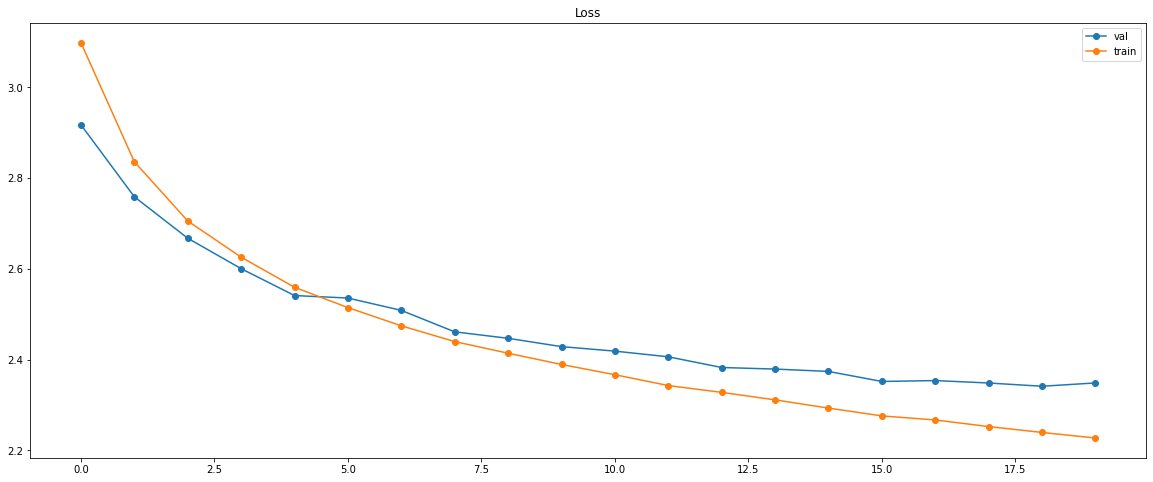

In [25]:
draw_graph(train_history, valid_history)

## Взглянем как работает на тесте 

In [51]:
seed = 2
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

batch = next(iter(test_loader))
input_batch = batch['input']
target_batch = batch['target']

# input_batch[0].shape, target_batch[0].shape
for i in range(2):
    output = model(input_batch[i].unsqueeze(0).to(device), target_batch[i].unsqueeze(0).to(device)[:,:-1])
    tokens = output.argmax(-1)
    print("Predict tokens: \n", tokens.cpu().squeeze(0).detach().numpy())
    print(train_dataset.decode(tokens.cpu().squeeze(0).detach().numpy()))
    print("Real tokens: \n",  target_batch[i].cpu().numpy())
    print(train_dataset.decode(target_batch[i]))
    print(1000*'-')

Predict tokens: 
 [  24 1080 1080  139   35  158   14   24  267   11   12   12   11   11
   11   11   11   11   11  560  560  560  560  560  560  560  560   11
   11   11]
['a', 'double', 'double', 'sitting', 'on', 'front', 'of', 'a', 'building', '.', '<EOS>', '<EOS>', '.', '.', '.', '.', '.', '.', '.', '"', '"', '"', '"', '"', '"', '"', '"', '.', '.', '.']
Real tokens: 
 [  2  24 271 702 139   5 158  14  24 267  11  12   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]
['<SOS>', 'a', 'green', 'bench', 'sitting', 'in', 'front', 'of', 'a', 'building', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
model.load_state_dict(torch.load('best-val-model_0.pt'))

<All keys matched successfully>

## Inseption и получение результатов


In [20]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
import imp
import beheaded_inception3
imp.reload(beheaded_inception3)
inception = beheaded_inception3.beheaded_inception_v3().train(False).to(device)

arrr


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


### Сгенерируем описание

In [24]:
from torch.distributions import Categorical

def generate_caption(image, is_inseption=True, caption_prefix=(2,), use_sampler=False, t=1, max_len=20):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    model.eval()
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).to(device)
        if is_inseption:
            vectors_8x8, vectors_neck, logits = inception(image[None])
        else:
            image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])(image)
            vectors_neck = resnet(image[None])
        # print(vectors_neck.shape)
        # print(vectors_8x8.shape, vectors_neck.shape, logits.shape)
        caption_prefix = list(caption_prefix)
        # 1. представляем caption_prefix в виде матрицы
        caption_prefix_tensor = torch.tensor(caption_prefix, dtype=torch.long).to(device).unsqueeze(0)
        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            preds = model(vectors_neck, caption_prefix_tensor) # [batch, len, classes]
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            probs = torch.softmax(preds[:,-1]/t, dim=-1)
            # 4. сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            if use_sampler:
                distribution = Categorical(probs)
                sampled = distribution.sample()
            else:
                sampled = probs.argmax(-1)
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся
            if sampled.item() == word2idx[EOS]:
                break
            # print(sampled.unsqueeze(0).shape)
            caption_prefix_tensor = torch.cat((caption_prefix_tensor, sampled.unsqueeze(0)), dim=1)
    # print(caption_prefix_tensor)
    return train_dataset.decode(caption_prefix_tensor.squeeze(0).cpu().numpy())

### Скачаем пару картинок, чтобы проверить качество:

--2021-07-06 14:34:51--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-07-06 14:34:51--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.006s  

2021-07-06 14:34:51 (8.76 MB/s) - ‘img.jpg’ saved [54731

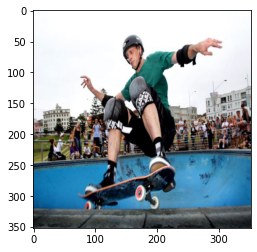

<SOS> a man riding a skateboard up the side of a ramp .
<SOS> a man riding a skateboard up the side of a ramp .
<SOS> a man riding a skateboard up the side of a ramp .
<SOS> a man riding a skateboard up the side of a ramp .
<SOS> a man riding a skateboard up the side of a ramp .


In [25]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
# !wget https://www.stefhermans.nl/flickrs/examples/cat.jpg -O img.jpg
# !wget https://github.com/yashk2810/Image-Captioning/blob/master/images/basketball.png?raw=true -O img.jpg
img = plt.imread('img.jpg')
print(img.shape)
img = cv2.resize(img, (352, 352)).astype('float32') / 255.
plt.imshow(img)
plt.show()

for i in range(5):
    print(' '.join(generate_caption(img, t=1, use_sampler=False)))

--2021-07-06 14:35:02--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-07-06 14:35:02--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K   426KB/s    in 0.2s    

2021-07-06 14:35:03 (426 KB/s) - ‘img.jpg’ saved [106870/106870]

(331, 645, 3)


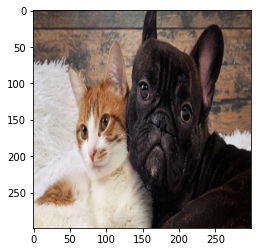

<SOS> a cat is laying on a couch with a remote control .
<SOS> a cat is laying on a couch with a remote control .
<SOS> a cat is laying on a couch with a remote control .
<SOS> a cat is laying on a couch with a remote control .
<SOS> a cat is laying on a couch with a remote control .


In [26]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
print(img.shape)
img = cv2.resize(img, (299, 299)).astype('float32') / 255.
plt.imshow(img)
plt.show()

for i in range(5):
    print(' '.join(generate_caption(img, t=5., use_sampler=False)))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

--2021-07-06 14:35:09--  https://cubiq.ru/wp-content/uploads/2018/12/image1-38-780x439.jpeg
Resolving cubiq.ru (cubiq.ru)... 5.101.153.74
Connecting to cubiq.ru (cubiq.ru)|5.101.153.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65489 (64K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  63.95K  --.-KB/s    in 0.05s   

2021-07-06 14:35:09 (1.21 MB/s) - ‘img.jpg’ saved [65489/65489]

(439, 780, 3)


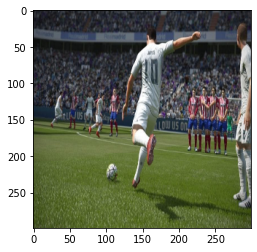

<SOS> a soccer player kicking a soccer ball on a field .
<SOS> a soccer player kicking a soccer ball on a field .
<SOS> a soccer player kicking a soccer ball on a field .
<SOS> a soccer player kicking a soccer ball on a field .
<SOS> a soccer player kicking a soccer ball on a field .


In [27]:
# !wget https://docs.gimp.org/2.10/ru/images/tutorials/quickie-jpeg-100.jpg -O img.jpg
# !wget https://st2.depositphotos.com/4318427/6334/i/950/depositphotos_63345113-stock-photo-football-match-for-children-training.jpg -O img.jpg
!wget https://cubiq.ru/wp-content/uploads/2018/12/image1-38-780x439.jpeg -O img.jpg
img = plt.imread('img.jpg')
print(img.shape)
img = cv2.resize(img, (299, 299)).astype('float32') / 255.
plt.imshow(img)
plt.show()

for i in range(5):
    print(' '.join(generate_caption(img, t=1, use_sampler=False)))

## Бонус: Achtung

# 1. Другая предобученная сеть resnet50 (результат не очень). Чтобы норм результат получить, надо дообучить и энкодер, и декодер (resnet) последний слой например хотя бы. Но обучить на полном датасете с картинками не успеваю, поэтому показал чисто инференс.

In [29]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)       
        return features

In [30]:
resnet = Resnet().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


--2021-07-06 14:38:57--  https://docs.gimp.org/2.10/ru/images/tutorials/quickie-jpeg-100.jpg
Resolving docs.gimp.org (docs.gimp.org)... 8.43.85.14, 8.43.85.13, 8.43.85.29, ...
Connecting to docs.gimp.org (docs.gimp.org)|8.43.85.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74348 (73K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  72.61K  --.-KB/s    in 0.1s    

2021-07-06 14:38:57 (730 KB/s) - ‘img.jpg’ saved [74348/74348]

(240, 320, 3)


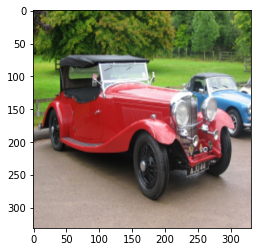

<SOS> a man is holding a bird in his hand .
<SOS> a man is holding a bird in his hand .
<SOS> a man is holding a bird in his hand .
<SOS> a man is holding a bird in his hand .
<SOS> a man is holding a bird in his hand .


In [36]:
!wget https://docs.gimp.org/2.10/ru/images/tutorials/quickie-jpeg-100.jpg -O img.jpg
# !wget https://st2.depositphotos.com/4318427/6334/i/950/depositphotos_63345113-stock-photo-football-match-for-children-training.jpg -O img.jpg
# !wget https://cubiq.ru/wp-content/uploads/2018/12/image1-38-780x439.jpeg -O img.jpg
img = plt.imread('img.jpg')
print(img.shape)
img = cv2.resize(img, (331, 331)).astype('float32') / 255.
plt.imshow(img)
plt.show()

for i in range(5):
    print(' '.join(generate_caption(img, is_inseption=False, t=1, use_sampler=False)))

# 2. В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части. 
Тут тоже нужен полноценный датасет с картинками, чтобы прогонять через инсепшн сеть и получать фичи 8х8х2048. Но я не стал искал датасет с картинками и прогонял просто 1х1х2048 вектор. Абсурдно конечно взвешивать один скрытый вектор, потому что во всех степах мы будем "взвешивать" только этот вектор, но сдеал упор на написании атеншн слоя и понимания его работы здесь.


In [40]:
import beheaded_inception3

class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        self.inception = beheaded_inception3.beheaded_inception_v3().train(False)
        for param in inception.parameters():
            param.requires_grad_(False)
        
    def forward(self, images):
        vectors_8x8, vectors_neck, logits = self.inception(images)
        return vectors_8x8, vectors_neck, logits

In [41]:
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        # source code of attention part: https://www.kaggle.com/mdteach/image-captioning-with-attention-pytorch
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

In [74]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, attention_dim, PAD_IDX, dropout=0.3, encoder_dim=2048):
        # vocab_size, embedding_dim, hidden_dim, n_layers, dropout, pad_idx, cnn_feature_size=2048
        super().__init__()
        
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.attention = Attention(encoder_dim, hidden_dim, attention_dim)
        
        self.h0 = nn.Linear(encoder_dim, hidden_dim)  
        self.c0 = nn.Linear(encoder_dim, hidden_dim)  
        self.lstm_cell = nn.LSTMCell(embedding_dim + encoder_dim,hidden_dim)        
        
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, features, captions):
        if len(features.shape) == 4: # [b,h,w,c]
            features = features.reshape(features.shape[0], -1, features.shape[-1])
        elif len(features.shape) == 2: # [b,c]
            features = features.unsqueeze(1) # [b,1,c]
        embeds = self.dropout(self.embedding(captions))
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        seq_length = len(captions[0]) - 1 
        batch_size = captions.size(0)
        num_features = features.size(1)
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for i in range(seq_length):
            alpha, context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, i], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.linear(h)
            preds[:,i] = output
            alphas[:,i] = alpha  
        
        return preds
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.h0(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.c0(mean_encoder_out)
        return h, c

    def generate_caption(self,image,inception,max_len=20):
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).to(device)
        vectors_8x8, vectors_neck, logits = inception(image[None])
        features = vectors_8x8.reshape(-1, 2048).unsqueeze(0)
        batch_size = features.size(0)
        # print(features.shape)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #starting input
        word = torch.tensor(2).view(1,-1).to(device)
        embeds = self.dropout(self.embedding(word))
        captions = []
        
        for i in range(max_len):
            _, context = self.attention(features, h)
          
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.linear(h)
            output = output.view(batch_size,-1)
        
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if predicted_word_idx.item() == word2idx[EOS]:
                break
            
            #send generated word as the next caption
            embeds = self.dropout(self.embedding(predicted_word_idx.unsqueeze(0)))
        
        #covert the vocab idx to words and return sentence
        return train_dataset.decode(captions)

In [75]:
vocab_size = len(vocab)
emb_dim = 300
hidden_dim = 512
attention_dim = 512
dropout = 0.5
PAD_IDX = word2idx[PAD]

model = Decoder(vocab_size, emb_dim, hidden_dim, attention_dim, PAD_IDX).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Decoder(
  (embedding): Embedding(9511, 300, padding_idx=0)
  (attention): Attention(
    (W): Linear(in_features=512, out_features=512, bias=True)
    (U): Linear(in_features=2048, out_features=512, bias=True)
    (A): Linear(in_features=512, out_features=1, bias=True)
  )
  (h0): Linear(in_features=2048, out_features=512, bias=True)
  (c0): Linear(in_features=2048, out_features=512, bias=True)
  (lstm_cell): LSTMCell(2348, 512)
  (linear): Linear(in_features=512, out_features=9511, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(device)

In [53]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        input, target = batch['input'].to(device), batch['target'].to(device)
        # print(target[:2,-1])
        # assert False
        optimizer.zero_grad()
        output = model(input, target)
        # print(output.shape, target.shape)
        # print(output.reshape(-1, output.size(-1)).shape, target[:, 1:].reshape(-1).shape)
        # assert False
        loss = criterion(output.reshape(-1, output.size(-1)), target[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        # history.append(loss.cpu().data.numpy())
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            input, target = batch['input'].to(device), batch['target'].to(device)
            optimizer.zero_grad()
            output = model(input, target)
            loss = criterion(output.reshape(-1, output.size(-1)), target[:, 1:].reshape(-1))
            epoch_loss += loss.item()
            # history.append(loss.cpu().data.numpy())
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def draw_graph(train_history, valid_history):
    fig, ax = plt.subplots(1, figsize=(20,8))
    ax.plot(np.arange(len(valid_history['loss'])), valid_history['loss'], label='val', marker='o')
    ax.plot(np.arange(len(train_history['loss'])), train_history['loss'], label='train', marker='o')
    ax.set_title('Loss')
    ax.legend()

In [54]:
train_history = {'loss': []}
valid_history = {'loss': []}

N_EPOCHS = 20
CLIP = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_loader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history['loss'].append(train_loss)
    valid_history['loss'].append(valid_loss)

    clear_output(True)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} || Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} ||  Val. PPL: {math.exp(valid_loss):7.3f}')
    # print(15*f'===========')

Epoch: 20 | Time: 2m 25s
	Train Loss: 2.307 || Train PPL:  10.049
	 Val. Loss: 2.455 ||  Val. PPL:  11.647


In [77]:
model.load_state_dict(torch.load('best-val-model_attn.pt'))

<All keys matched successfully>

In [62]:
seed = 2
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

batch = next(iter(test_loader))
input_batch = batch['input']
target_batch = batch['target']

# input_batch[0].shape, target_batch[0].shape
for i in range(2):
    output = model(input_batch[i].unsqueeze(0).to(device), target_batch[i].unsqueeze(0).to(device)[:,:-1])
    tokens = output.argmax(-1)
    print("Predict tokens: \n", tokens.cpu().squeeze(0).detach().numpy())
    print(train_dataset.decode(tokens.cpu().squeeze(0).detach().numpy()))
    print("Real tokens: \n",  target_batch[i].cpu().numpy())
    print(train_dataset.decode(target_batch[i]))
    print(1000*'-')

Predict tokens: 
 [ 24  96 371  35  35 158  14  24 267  11  12  11  11  11  11  11  11  11
  11  11  11  11  11  11  11  11  11  11  11]
['a', 'street', 'bus', 'on', 'on', 'front', 'of', 'a', 'building', '.', '<EOS>', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
Real tokens: 
 [  2  24 271 702 139   5 158  14  24 267  11  12   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]
['<SOS>', 'a', 'green', 'bench', 'sitting', 'in', 'front', 'of', 'a', 'building', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [57]:
inception = EncoderCNN().to(device)

arrr


--2021-07-06 15:54:48--  https://cubiq.ru/wp-content/uploads/2018/12/image1-38-780x439.jpeg
Resolving cubiq.ru (cubiq.ru)... 5.101.153.74
Connecting to cubiq.ru (cubiq.ru)|5.101.153.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65489 (64K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  63.95K  --.-KB/s    in 0.05s   

2021-07-06 15:54:48 (1.18 MB/s) - ‘img.jpg’ saved [65489/65489]

(439, 780, 3)


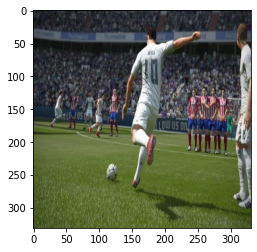

a person holding a small dog in a field . <EOS>


In [80]:
# !wget https://docs.gimp.org/2.10/ru/images/tutorials/quickie-jpeg-100.jpg -O img.jpg
# !wget https://st2.depositphotos.com/4318427/6334/i/950/depositphotos_63345113-stock-photo-football-match-for-children-training.jpg -O img.jpg
!wget https://cubiq.ru/wp-content/uploads/2018/12/image1-38-780x439.jpeg -O img.jpg
img = plt.imread('img.jpg')
print(img.shape)
img = cv2.resize(img, (331, 331)).astype('float32') / 255.
plt.imshow(img)
plt.show()

model.eval()
with torch.no_grad():
    print(' '.join(model.generate_caption(img, inception)))